In [ ]:
""" 
Created by Velat Dicleli https://github.com/VelatDicleli

dataset: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset/

"""


import numpy as np 
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import random
from PIL import Image
from pathlib import Path
import torchvision
import os


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:

train_dir=Path("Cars Dataset/train")
test_dir=Path("Cars Dataset/test")

In [376]:
def visualize_one(path):
    img_list=list(path.glob("*/*.jpg"))
    rand_img=random.choice(img_list)
    img=Image.open(rand_img)
    img_shape=img.size
    print(img_shape)
    img.info
    return img
    
img=visualize_one(train_dir) 

(300, 168)


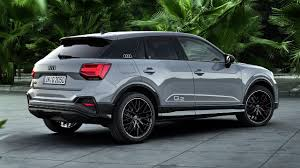

In [377]:
img

In [378]:
def visualize_with_plt(img):

    img_as_array = np.asarray(img)
    plt.figure(figsize=(10, 5))
    plt.imshow(img_as_array)
    plt.title(f" Image shape: {img_as_array.shape} -> [height, width, color_channels]")
    plt.axis(False);


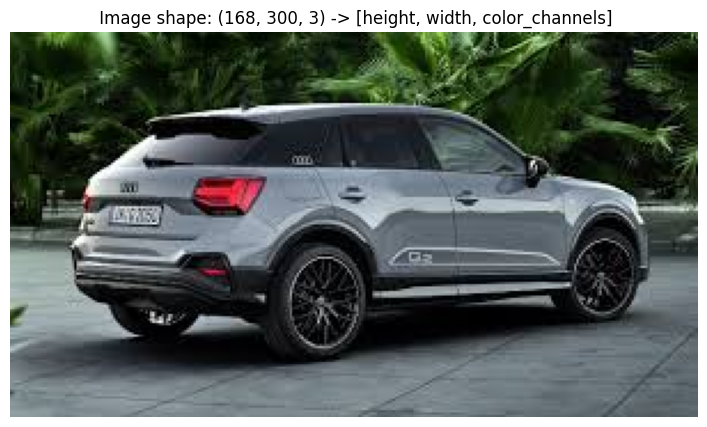

In [379]:
visualize_with_plt(img)

In [ ]:
transformer= transforms.Compose([
    transforms.Resize(size=(164,164)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor() # everything between 0-1
    

])

In [ ]:
train_data=datasets.ImageFolder(
                                root=train_dir,
                                transform=transformer,
                                target_transform=None
                                
                                )

test_data=datasets.ImageFolder(
                               root=test_dir,
                               transform=transformer,
                               
                              )

In [ ]:
train_data.class_to_idx

In [ ]:
class_names=train_data.classes
class_names

In [380]:
image,label=train_data[0][0],train_data[0][1]

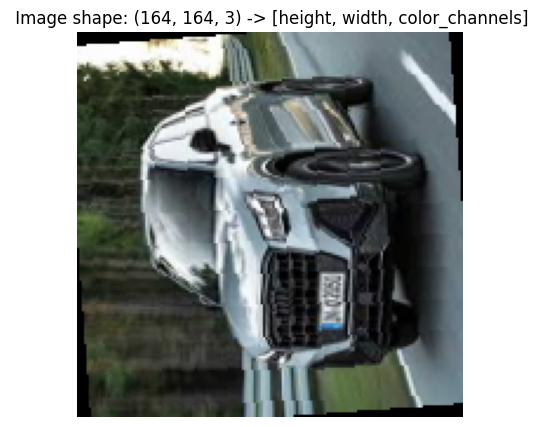

In [381]:
visualize_with_plt(image.permute(1,2,0))

In [ ]:
train_dataloader=DataLoader(
                            dataset=train_data,
                            batch_size=32,
                            shuffle=True,
                            num_workers=1
)

test_dataloader=DataLoader(
                           dataset=test_data,
                           batch_size=32,
                           shuffle=False,
                           num_workers=1

)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader))

In [ ]:
img_custom.shape

In [ ]:
label_custom

In [ ]:
class CarClassification(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)

        )

        self.conv_block_2=nn.Sequential(

            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        
        )
        
        
        
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*41*41,hidden_units*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units*4,output_shape),
            
            
        )

    def forward(self,x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

torch.manual_seed(21)

model_1=CarClassification(3,24,len(train_data.classes)).to(device)
model_1

In [ ]:
def train_step(model,dataloader,loss_fn,optimizer):
    
    model.train()
    
    
    train_loss, train_acc = 0, 0
    
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

       
        y_pred = model(X)

        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        
        optimizer.zero_grad()

        
        loss.backward()

       
        optimizer.step()

        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    model.eval() 
    
    
    test_loss, test_acc = 0, 0
    
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
    
           
            test_pred_logits = model(X)

            
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            
            #test_pred_labels = test_pred_logits.argmax(dim=1)
            test_pred_probs = torch.softmax(test_pred_logits, dim=1)
            test_pred_labels = test_pred_probs.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau





def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=13, threshold=0.001, verbose=True)
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        scheduler.step(test_loss)


    
    return results

In [ ]:

torch.manual_seed(14) 
torch.cuda.manual_seed(14)


NUM_EPOCHS = 200


model_1 = CarClassification(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=25, 
                  output_shape=len(train_data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)


from timeit import default_timer as timer 
start_time = timer()

 
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

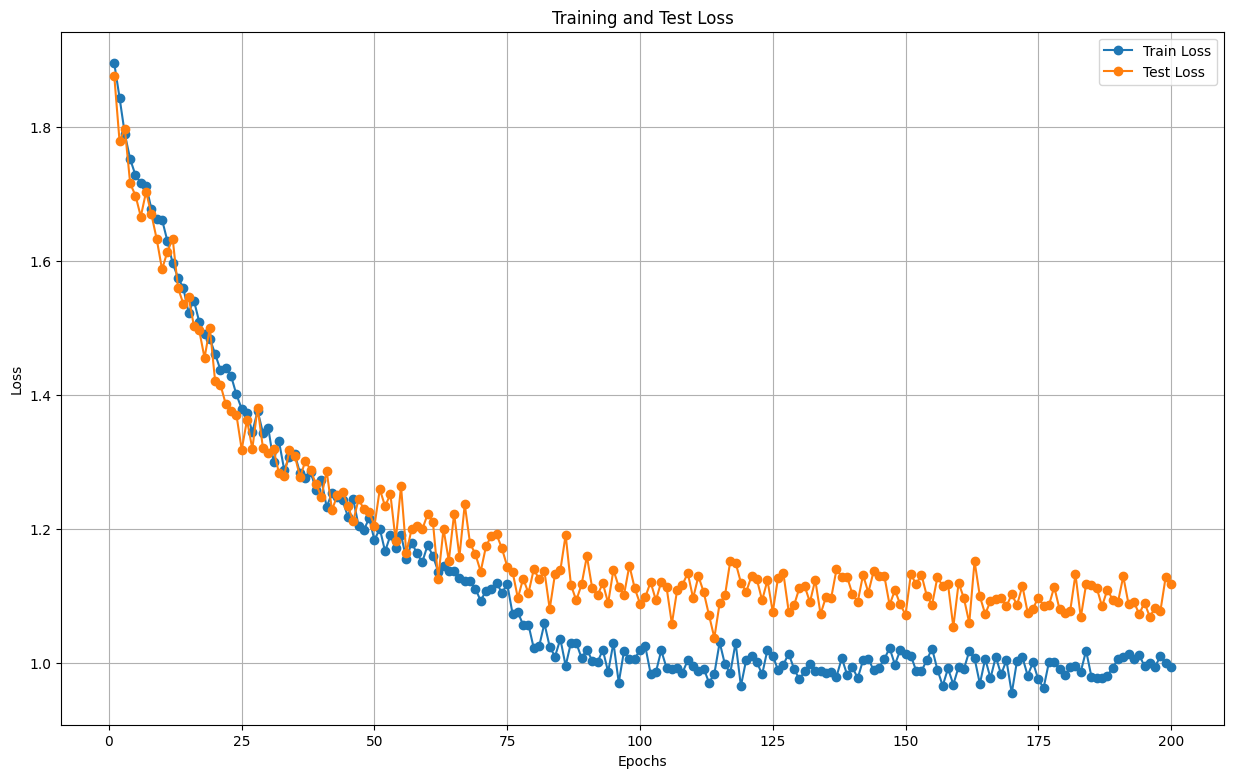

In [382]:
import matplotlib.pyplot as plt

def plot_loss(results):
    plt.figure(figsize=(15, 9))
    epochs = range(1, len(results['train_loss']) + 1)
    
    plt.plot(epochs, results['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, results['test_loss'], label='Test Loss', marker='o')
    
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()





plot_loss(model_1_results)


In [ ]:
transformm=transforms.Compose([transforms.Resize((164,164))])

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names, 
                        transform=None,
                        device: torch.device = device):
    
    
    
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    
    target_image = target_image / 255. 
    
   
    if transform:
        target_image = transform(target_image)
    
    
    model.to(device)
    
    
    model.eval()
    with torch.inference_mode():
        
        target_image = target_image.unsqueeze(dim=0)
    
       
        target_image_pred = model(target_image.to(device))
        
    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) 
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [383]:
torch.save(model_1,"model.pth")


In [384]:
mymodel=torch.load("model.pth")

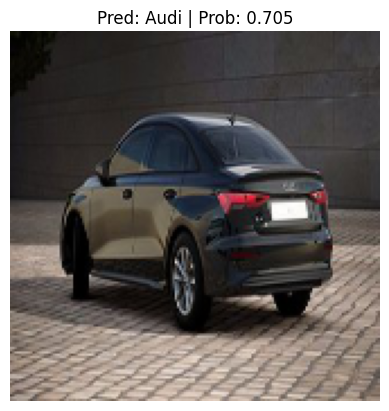

In [387]:
pred_and_plot_image(mymodel,"e82eb696-e1ac-4561-bd7f-87a92f63beac.jpg",class_names,transformm,device)